In [1]:
import csv
import json
import jsonpickle
from collections import Counter
from dataset_utils import DatasetEntry

# Read annotated datasets

In [2]:
import numpy as np

# Path to extension dataset
batch_path_ext = "batch_results/Batch_4278643_batch_results_ext.csv"
# Path to main dataset
batch_path_main = "batch_results/Batch_4265208_batch_results_main.csv"

csv_lines_main = []
with open(batch_path_main, "r") as csv_file:
    csv_reader = csv.reader(csv_file)
    csv_lines_main = list(csv_reader)

csv_lines_ext = []
with open(batch_path_ext, "r") as csv_file:
    csv_reader = csv.reader(csv_file)
    csv_lines_ext = list(csv_reader)

# Get all columns but leave out 'Approve' 'Reject' since they are not in the Data yet
columns_main = csv_lines_main[0][:-2]
data_lines_main = csv_lines_main[1:]

csv_entries_main = []
for line in data_lines_main:
    entry = dict()
    for idx, col in enumerate(columns_main):
        entry[col] = line[idx]
    csv_entries_main.append(entry)
    
# Get all columns but leave out 'Approve' 'Reject' since they are not in the Data yet
columns_ext = csv_lines_ext[0][:-2]
data_lines_ext = csv_lines_ext[1:]

csv_entries_ext = []
for line in data_lines_ext:
    entry = dict()
    for idx, col in enumerate(columns_ext):
        entry[col] = line[idx]
    csv_entries_ext.append(entry)
    
csv_entries = csv_entries_main + csv_entries_ext
print(f"Total entries collected: {len(csv_entries)}")

Total entries collected: 10809


# General worker statistics

Num Workers: 246
Mean of assignments one worker has done: 43.9390243902439
Median of assignments one worker has done: 4.0
Std Dev of assignments one worker has done: 169.06376149391943
Percent of workers did 10 or less: 0.6788617886178862
Percent of workers did only one task: 0.2926829268292683
Number of workers did only one task: 72


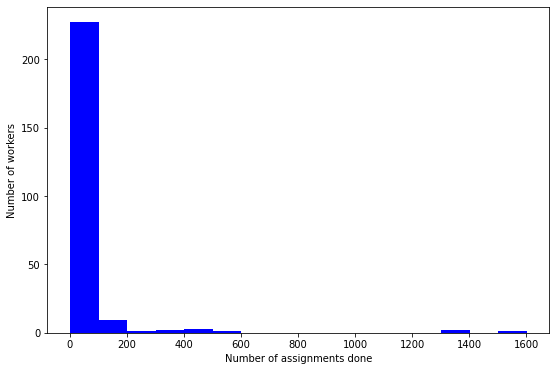

In [3]:
import numpy as np
worker_num_assignments = {}
# Retrieve worker ids from dataset
for entry in csv_entries:
    worker_id = entry['WorkerId']
    occurences = worker_num_assignments.get(worker_id, 0)
    occurences += 1
    worker_num_assignments[worker_id] = occurences

from statistics import median, mean, stdev

# Get only the number of assignments of individual workers
num_assignments = [worker_num_assignments[worker] for worker in worker_num_assignments.keys()]
# Sort them from low to high
num_assignments = sorted(num_assignments)

print("Num Workers: " + str(len(num_assignments)))
print("Mean of assignments one worker has done: " + str(mean(num_assignments)))
print("Median of assignments one worker has done: " + str(median(num_assignments)))
print("Std Dev of assignments one worker has done: " + str(stdev(num_assignments)))

print(f"Percent of workers did 10 or less: {num_assignments.index(11)/len(num_assignments)}")
print(f"Percent of workers did only one task: {num_assignments.index(2)/len(num_assignments)}")
print(f"Number of workers did only one task: {num_assignments.index(2)}")


# Plot histogram over num workers:
import matplotlib.pyplot as plt
binwidth = 100
plt.figure(figsize=(9,6))
plt.hist([num_assignments], color=['blue'], bins=np.arange(min(num_assignments), max(num_assignments) + binwidth, binwidth))
plt.xlabel("Number of assignments done")
plt.ylabel("Number of workers")
plt.show()



# Poem answer distribution

In [4]:
from dataset_utils import DatasetEntry
import json
from collections import Counter

pair_ids = []
dataset_entries = {}
for entry in csv_entries:
    # Get entry id
    pair_id = entry['Input.pair_id']
    # If entry is not yet in dict create it
    if pair_id not in dataset_entries.keys():
        pair_ids.append(pair_id)
        # Get poem details
        poem1 = entry['Input.poem1']
        poem2 = entry['Input.poem2']
        dataset1 = entry['Input.poem1_dataset']
        dataset2 = entry['Input.poem2_dataset']

        dataset_entries[pair_id] = DatasetEntry(pair_id, poem1, poem2, dataset1, dataset2)

    dataset_entry = dataset_entries[pair_id]
    submitted_values = json.loads(str(entry['Answer.taskAnswers']))[0]
    dataset_entry.update_values(submitted_values)   
    dataset_entries[pair_id] = dataset_entry


vote_ratios_in_each_cat = {}
votes_in_each_cat_1 = {}
votes_in_each_cat_2 = {}

for cat in ["coherent", "grammatical", "moved", "real", "rhyming", "readable", "comprehensible", "intense", "liking", "melodious"]:
    cat_entries = []
    for key in dataset_entries:
        cat_entries.extend(getattr(dataset_entries[key], cat))
    cat_counter = Counter(cat_entries)
    votes_1 = cat_counter['1']
    votes_2 = cat_counter['2']
    vote_ratios_in_each_cat[cat] = votes_1/(votes_1+votes_2)
    votes_in_each_cat_1[cat] = votes_1
    votes_in_each_cat_2[cat] = votes_2


print(f"Relative ratio between votes:\n{vote_ratios_in_each_cat}\n")
print(f"Absolute count of votes for poem 1:\n{votes_in_each_cat_1}\n")
print(f"Absolute count of votes for poem 2:\n{votes_in_each_cat_2}\n")

10809
Relative ratio between votes:
{'coherent': 0.5461942257217848, 'grammatical': 0.5451443569553805, 'moved': 0.5601049868766405, 'real': 0.5653543307086614, 'rhyming': 0.5606299212598426, 'readable': 0.5514435695538058, 'comprehensible': 0.5585301837270341, 'intense': 0.5398950131233596, 'liking': 0.5627296587926509, 'melodious': 0.5380577427821522}

Absolute count of votes for poem 1:
{'coherent': 2081, 'grammatical': 2077, 'moved': 2134, 'real': 2154, 'rhyming': 2136, 'readable': 2101, 'comprehensible': 2128, 'intense': 2057, 'liking': 2144, 'melodious': 2050}

Absolute count of votes for poem 2:
{'coherent': 1729, 'grammatical': 1733, 'moved': 1676, 'real': 1656, 'rhyming': 1674, 'readable': 1709, 'comprehensible': 1682, 'intense': 1753, 'liking': 1666, 'melodious': 1760}



# Check on suspicious activity in dataset

In [5]:
import json
from collections import Counter
# Create stats about worker preferences
vote_preference_per_worker = {}
for entry in csv_entries:
    worker_id = entry['WorkerId']
    worker_votes = vote_preference_per_worker.get(worker_id, [])
    votes = json.loads(entry['Answer.taskAnswers'])[0]
    for key in votes:
        if votes[key]['1']:
            worker_votes.append(1)
        elif votes[key]['2']:
            worker_votes.append(2)
        else:
            worker_votes.append(0)
    vote_preference_per_worker[worker_id] = worker_votes

def calc_worker_pref_ratio(vote_list):
    counter = Counter(vote_list)
    votes_1 = counter[1]
    votes_2 = counter[2]
    num_votes = votes_1 + votes_2
    if votes_1 == 0:
        ratio = 0.
    if votes_2 == 0:
        ratio = 1.
    else:
        ratio = votes_1 / (votes_1 + votes_2)
    return ratio, num_votes
    
vote_preference_per_worker = {worker_id: calc_worker_pref_ratio(vote_preference_per_worker[worker_id]) for worker_id in vote_preference_per_worker}

sus_workers = [(worker_id, vote_preference_per_worker[worker_id][0], vote_preference_per_worker[worker_id][1]) for worker_id in vote_preference_per_worker if not 0.35 < vote_preference_per_worker[worker_id][0] < 0.65 and vote_preference_per_worker[worker_id][1] > 20]
print([sus_w[0] for sus_w in sus_workers])
print(len(sus_workers))
print(sus_workers)

['A1CF6U3GF7DZEJ', 'A3P7M9666KJCP', 'A681XM15AN28F', 'A10NF5TK6IFNX6', 'A2HM35CWB7IIFM', 'A1EZV3Q6PGMQTY', 'A1BQBQG2GNY8AY', 'AQN3RS63MEPQA', 'A3UDP95JGEX3H1', 'A1RQP36KU5S3B1', 'A1S88VQY8G8CNC', 'A3VLTC2Z0NPV7J', 'A3728C36S28ER2', 'ARPBDM5QZ4XQC', 'A2CHN7YRG2LE9E', 'A1CKPHJ229URZM', 'A2BK6PDD4J2X1T', 'A26BHQZCY7GRNP', 'A12NVHDVHC2V8T', 'A3M3VOCB8C2YK4', 'A1TJ3LM4KVXNWG', 'A1Z268VWTV5HY0', 'A37L9NNKEP0RHE', 'A2J3YWMJPF4N6D', 'A2L6JHIJDE1F2X', 'A3IDJVAGS1SCJ5']
26
[('A1CF6U3GF7DZEJ', 0.7370892018779343, 426), ('A3P7M9666KJCP', 0.6793893129770993, 131), ('A681XM15AN28F', 0.847457627118644, 1652), ('A10NF5TK6IFNX6', 0.7448979591836735, 98), ('A2HM35CWB7IIFM', 0.7297297297297297, 37), ('A1EZV3Q6PGMQTY', 0.7083333333333334, 24), ('A1BQBQG2GNY8AY', 0.7636363636363637, 55), ('AQN3RS63MEPQA', 0.71875, 32), ('A3UDP95JGEX3H1', 0.75, 32), ('A1RQP36KU5S3B1', 0.7692307692307693, 26), ('A1S88VQY8G8CNC', 0.3333333333333333, 21), ('A3VLTC2Z0NPV7J', 0.6556962025316456, 395), ('A3728C36S28ER2', 0.950537

# Check on individual workers

In [ ]:
worktime_measures = []
last_submission_date = ""
first_submission_date = ""
for entry in csv_entries:
    if (entry['WorkerId'] == 'AXQWKUJF7SQXP'):
        worktime = int(entry['WorkTimeInSeconds'])
        worktime_measures.append(worktime)
        if worktime < 10:
            print(entry['Input.poem1'].replace("<br>", "\n"))
            print("=====")
            print(entry['Input.poem2'].replace("<br>", "\n"))
            print(entry['Answer.taskAnswers'])
            print()
            print()
            
        last_submission_date = entry['SubmitTime']
from statistics import mean
print(len(worktime_measures))
print(mean(worktime_measures))
print(last_submission_date)
        
        

# Batch review and rejection of workers

In [ ]:
batch_path = "batch_results/Batch_4265208_batch_results_main.csv"
with open(batch_path, "r") as f:
    lines = f.readlines()

num_to_reject = sum([w[2] for w in sus_workers])
print("Number of expected rejections: " + str(num_to_reject))
reject_workers = [w[0] for w in sus_workers]
reviewed_lines = []
rejections = 0
for idx, line in enumerate(lines):
    line = line.strip()
    if idx == 0:
        reviewed_lines.append(line)
        continue
    reject_line = False
    for worker in reject_workers:
        if worker in line:
            reject_line = True
            rejections += 1
            break
    if reject_line:
        line = line + ',"","Worker not trustworthy since one option was too many times preferred over another in a statistically very unlikely scenario"'
    else:
        line = line + ',"",""'
        
    reviewed_lines.append(line)

print(len(reviewed_lines))
print("Rejections: " + str(rejections))
with open("batch_results/Batch_4265208_batch_results_reviewed.csv", "w+") as f:
    for line in reviewed_lines:
        f.write(line + "\n")
        
            

# Get stats over consensus of votes

In [6]:
final_dataset = []
for entry in dataset_entries:
    final_dataset.append(dataset_entries[entry].get_consensus())

vote_ratios_in_each_cat = {}
for cat in ["coherent", "grammatical", "moved", "real", "rhyming", "readable", "comprehensible", "intense", "liking", "melodious"]:
    cat_entries = []
    for elem in final_dataset:
        cat_entries.append(getattr(elem, cat))
    cat_counter = Counter(cat_entries)
    votes_1 = cat_counter['1']
    votes_2 = cat_counter['2']
    vote_ratios_in_each_cat[cat] = votes_1/(votes_1+votes_2)

print(vote_ratios_in_each_cat)

{'coherent': 0.5620853080568721, 'grammatical': 0.54739336492891, 'moved': 0.576303317535545, 'real': 0.5682464454976304, 'rhyming': 0.5710900473933649, 'readable': 0.556872037914692, 'comprehensible': 0.5710900473933649, 'intense': 0.5511848341232227, 'liking': 0.5824644549763033, 'melodious': 0.5412322274881517}


In [ ]:
# Distribution of datasets

{'lstm': 326, 'gutenberg': 1708, 'true_poetry': 377, 'hafez': 376, 'jhamtani': 344, 'ngram': 408, 'gpt2': 343, 'deepspeare': 338}
['lstm', 'gutenberg', 'true_poetry', 'hafez', 'jhamtani', 'ngram', 'gpt2', 'deepspeare']
[326, 1708, 377, 376, 344, 408, 343, 338]


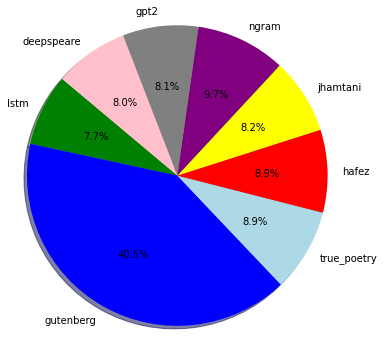

In [8]:
from collections import Counter
import matplotlib.pyplot as plt


dataset_occs = []
for id, entry in dataset_entries.items():
    dataset_occs.extend([entry.dataset1, entry.dataset2])

dataset_count = dict(Counter(dataset_occs))
dataset_names = [k for k in dataset_count]
occs = [dataset_count[k] for k in dataset_names]
print(dataset_count)
print(dataset_names)
print(occs)

labels = dataset_names
sizes = occs
colors = ['green', 'blue', 'lightblue', 'red', 'yellow', 'purple', 'gray', 'pink']

# plot
plt.figure(figsize=(6,6))
plt.pie(sizes,              # data
        labels=labels,      # slice labels
        colors=colors,      # array of clors
        autopct='%1.1f%%',  # print the values inside the wedges
        shadow=True,        # enable shadow
        startangle=140)     # startin angle

plt.axis('equal')

plt.show()

# Accuracy of annotators in category 'real'

In [12]:
votes_real_correct = 0
votes_real_false = 0
for key in dataset_entries:
    entry = dataset_entries[key]
    if entry.dataset1 == "gutenberg" and entry.dataset2 == "gutenberg":
        votes_real_correct += 1
        continue
    
    real = "1" if entry.dataset1 == "gutenberg" else "2"
    for vote in entry.real:
        if real == vote:
            votes_real_correct += 1
        else:
            votes_real_false += 1
    
print(f"Annotations on real correct:\t{votes_real_correct}")
print(f"Annotations on real wrong:\t{votes_real_false}")
real_acc = float(votes_real_correct) / float(votes_real_correct + votes_real_false)
print(f"Accuracy of annotators choosing Real: {real_acc}")
    

Annotations on real correct:	2048
Annotations on real wrong:	1662
Accuracy of annotators choosing Real: 0.5520215633423181


# Correlation analysis between features

coherent - coherent:			0.9999999999999994
coherent - grammatical:			0.17273030189217853
coherent - moved:			0.22184889380871117
coherent - real:			0.18417085888001306
coherent - rhyming:			0.1524120874499733
coherent - readable:			0.17219782033354106
coherent - comprehensible:			0.15007660323098543
coherent - intense:			0.045076633841554414
coherent - liking:			0.16365343477292296
coherent - melodious:			0.1576747695033598
grammatical - coherent:			0.17273030189217853
grammatical - grammatical:			1.0
grammatical - moved:			0.19727465510823144
grammatical - real:			0.16545405051024548
grammatical - rhyming:			0.20721031798222822
grammatical - readable:			0.20595365599807514
grammatical - comprehensible:			0.12139072642435457
grammatical - intense:			0.09659365192499869
grammatical - liking:			0.17984239476991737
grammatical - melodious:			0.15296775269944807
moved - coherent:			0.22184889380871117
moved - grammatical:			0.19727465510823144
moved - moved:			1.0
moved - real:			0.16552381

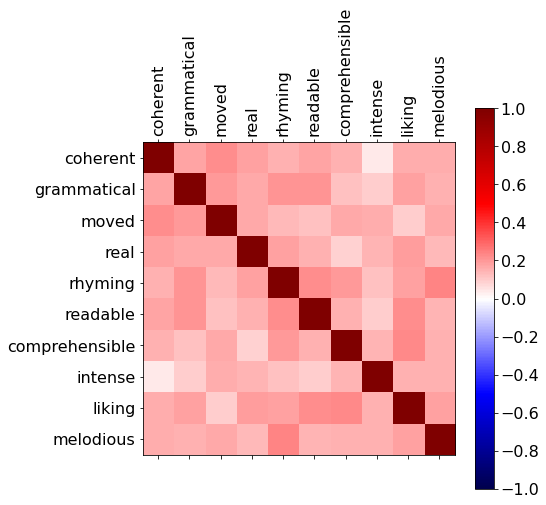

In [13]:
from scipy import stats
from statistics import median
import numpy as np
import matplotlib.pyplot as plt

categories = ["coherent", "grammatical", "moved", "real", "rhyming", "readable", "comprehensible", "intense", "liking", "melodious"]

# dict mit cat als keys was als entry wieder alle categorien hat 

votes_per_cat = {}
for cat in categories:
    votes_per_cat[cat] = []
    for key in dataset_entries:
        votes = [int(v) for v in getattr(dataset_entries[key], cat)]
        if len(votes) > 1:
            vote = median(votes)
            votes_per_cat[cat].append(vote)

correlations = []
for i, cat1 in enumerate(categories):
    correlations.append([])
    for j, cat2 in enumerate(categories):
        corr = stats.pearsonr(votes_per_cat[cat1], votes_per_cat[cat2])[0]
        correlations[i].append(corr)
        print(f"{cat1} - {cat2}:\t\t\t{corr}")

fig = plt.figure(figsize=(7,7))
plt.rcParams.update({'font.size': 16})
ax = fig.add_subplot(111)

cax = ax.matshow(correlations, cmap=plt.get_cmap('seismic'), vmin=-1, vmax=1)
fig.colorbar(cax, ticks=np.arange(-1, 1.2, 0.2))
xaxis = np.arange(len(categories))
print(xaxis)
ax.set_xticks(xaxis)
ax.set_yticks(xaxis)

ax.set_xticklabels(categories, rotation=90)
ax.set_yticklabels(categories)

plt.show()

In [ ]:
# Statistic over work times

244.82347449053887
978


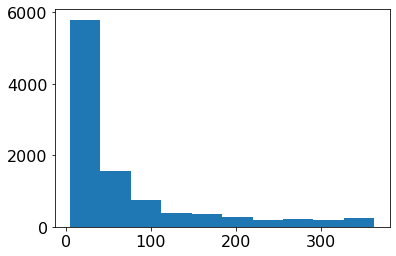

In [14]:
from statistics import mean, stdev
import matplotlib.pyplot as plt
assign_times = []
for ent in csv_entries:
    assign_times.append(int(ent['WorkTimeInSeconds']))

    
mean_time = mean(assign_times)
std_time = stdev(assign_times)
print(std_time)

cleaned_times = [t for t in assign_times if (abs(t - mean_time) < std_time)]

less_than_30 = len([t for t in assign_times if t < 10])
print(less_than_30)

plt.hist(cleaned_times)
plt.show()
